<a href="https://colab.research.google.com/github/DylanCTY/Trial-space/blob/main/Lecture3(0501).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling
Topic Modeling is a type of statistical modeling for discovering the abstract "topics" that occur in a collection of documents. It is a frequent technique in text mining for uncovering hidden semantic structures in a text body. This process is useful in various applications like organizing large archives of texts, summarizing information, and aiding in understanding the main themes of texts without reading them in full. We will look at several techniques for topic modeling including LDA, LSA, NMF and BERTopic.


## LDA

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download() to look at options

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [4]:
# Function to preprocess the data
def preprocess_texts(documents):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    preprocessed_texts = []
    for text in documents:
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        preprocessed_texts.append(tokens)  # Append list of tokens directly, without joining them into a string

    return preprocessed_texts


In [5]:
# Sample data and preprocessing
documents = [
    "Sugar is bad to consume. My sister likes to have sugar, but not my father.",
    "My father spends a lot of time driving my brother around to baseball practice.",
    "Some health experts suggest that driving may cause increased stress and blood pressure.",
    "I often feel pressure to perform well at school, but my father never seems to drive my sister to do better.",
    "Health professionals say that Sugar is not good for your lifestyle."
]

# 'texts' will be a list of lists of tokens
texts = preprocess_texts(documents)

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]


In [7]:
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.055*"health" + 0.054*"driving" + 0.054*"pressure" + 0.053*"blood" + 0.053*"increased"')
(1, '0.068*"sugar" + 0.068*"father" + 0.048*"sister" + 0.029*"like" + 0.029*"brother"')


The variations in output each time you run an LDA model are due to the stochastic nature of the algorithms used in Latent Dirichlet Allocation. Here are the key reasons for these variations:

* Random Initialization: Most LDA implementations (including gensim) start with a random initialization of the topic assignments for each word. This randomness affects the subsequent updates and iterations of the algorithm.

* Sampling Methods: LDA often uses sampling methods like Gibbs sampling or variational Bayes inference to estimate the distributions of topics over words and documents. These methods inherently involve randomness, which can lead to different results each time the model is trained, especially if the number of iterations is not large enough to reach convergence.

* Convergence Issues: If the LDA model doesn't fully converge due to too few iterations or poor parameter settings (like learning rates), the output may vary significantly between runs. Achieving convergence in probabilistic models can be challenging and might require tuning parameters such as the number of iterations and choosing appropriate hyperparameters (like alpha and beta for LDA).

* Number of Topics: The choice of the number of topics (num_topics) can also influence the stability of your topics. Too few or too many topics can lead to overfitting or underfitting, respectively, making the model sensitive to initial conditions or specific samples of data.

### Ensuring Consistency

To reduce the variability in your LDA models, you can take the following steps:

* Set a Random Seed: Most LDA implementations allow you to set a random seed to make the results reproducible. This is done by fixing the seed for the random number generator used by the model.

* Increase the Number of Iterations: Allowing more iterations can help the model converge more consistently, which, in turn, makes the output more stable.

* Tune Hyperparameters: Adjusting the hyperparameters, such as alpha (document-topic density) and beta (topic-word density), can help in achieving better and more consistent results. These parameters control the sparsity of the topics extracted by the model.

* Extensive Preprocessing: More consistent and thorough preprocessing of the text data can lead to less noise in the input, which helps stabilize the output.

```
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',  # can be set as a scalar like '0.01' or 'auto' for learning the optimal alpha
    eta='auto'     # eta is another name for beta in gensim, similarly settable
)
```




In [8]:
# Set parameters
num_topics = 3
passes = 100

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes,random_state=100)

# Display the topics
topics = lda.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.083*"health" + 0.048*"driving" + 0.048*"increased" + 0.048*"may" + 0.048*"suggest"')
(1, '0.056*"sister" + 0.056*"pressure" + 0.056*"perform" + 0.056*"often" + 0.056*"seems"')
(2, '0.084*"sugar" + 0.083*"father" + 0.048*"spends" + 0.048*"baseball" + 0.048*"around"')


We can also display the topics as wordclouds:

In [9]:
%pip install wordcloud

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

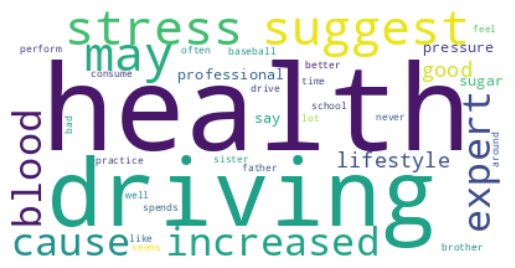

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, 200)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    return plt

create_wordcloud(lda, topic=0)

#Coherence Score
Coherence measures the degree of semantic similarity between high scoring words in the topic. These scores help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [11]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)


Coherence Score: 0.35277825048982697


# Number of Topics

[0.3076742654074003, 0.35277825048982697, 0.36186683579444917, 0.3833486338856585]


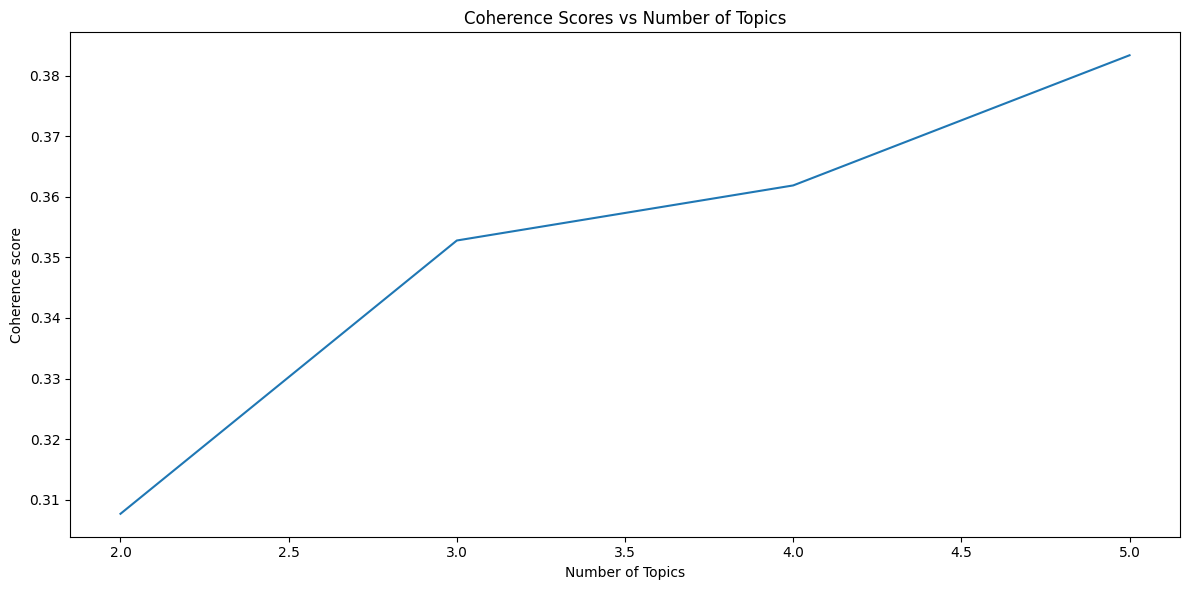

In [12]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()


# LSA

In [13]:
from gensim.models import LdaModel,CoherenceModel,TfidfModel,Nmf,LsiModel

In [14]:
# train LSA model
num_topics = 4
lsa_model = LsiModel(corpus, num_topics=num_topics, id2word=dictionary,random_seed=100)
topics = lsa_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

coherence_model_lsa = CoherenceModel(model=lsa_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score:', coherence_lsa)

(0, '0.406*"father" + 0.323*"sister" + 0.290*"pressure" + 0.273*"sugar" + 0.207*"often"')
(1, '-0.359*"driving" + -0.304*"health" + -0.271*"may" + -0.271*"blood" + -0.271*"increased"')
(2, '-0.594*"sugar" + -0.231*"consume" + -0.231*"like" + -0.231*"bad" + 0.225*"pressure"')
(3, '0.298*"lot" + 0.298*"spends" + 0.298*"brother" + 0.298*"practice" + 0.298*"around"')
Coherence Score: 0.28715627951357736


##NMF

In [15]:
# train NMF model
nmf_model = Nmf(corpus,id2word=dictionary, num_topics=num_topics,passes=20,random_state=100)
topics = nmf_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

coherence_model_nmf = CoherenceModel(model=nmf_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print('Coherence Score:', coherence_nmf)


(0, '0.168*"health" + 0.166*"say" + 0.166*"lifestyle" + 0.166*"professional" + 0.166*"good"')
(1, '0.096*"father" + 0.063*"around" + 0.063*"baseball" + 0.063*"time" + 0.063*"brother"')
(2, '0.102*"pressure" + 0.082*"stress" + 0.082*"may" + 0.082*"expert" + 0.082*"increased"')
(3, '0.238*"sugar" + 0.136*"sister" + 0.125*"father" + 0.119*"like" + 0.119*"bad"')
Coherence Score: 0.2597824319552638


##LSA vs NMF
* Comparison and Use Cases Interpretability: NMF often provides more interpretable topics than LSA because of the non-negativity constraint, which aligns better with the intuitive notion of adding up features to form a dataset.
* Handling of Synonyms and Polysemy: LSA can handle synonyms better due to its dimensional reduction approach, but it struggles with polysemy (words with multiple meanings) because all occurrences of a word are mapped to a single point in semantic space.
* Usage: LSA is often preferred for tasks involving similarity and information retrieval due to its robust handling of noise and ability to capture underlying semantic patterns. NMF is favored for clustering and classification tasks where interpretability of components (topics) is crucial.

 Both LSA and NMF are valuable tools in the text mining and information retrieval toolkit, chosen based on the specific requirements of clarity, ease of interpretation, and the nature of the text data.

## BERT Topic Modeling
BERTopic is a topic modeling tool that leverages transformers and language models like BERT for generating topics from textual data. Unlike traditional methods such as LDA, BERTopic utilizes contextual embeddings, which can capture the meanings of words more effectively in different contexts.

Since the example we have used thus far is too small for this technique (due to embeddings - we will discuss this later), we will use the first 100 reviews from the ``Reviews.csv`` file.

In [ ]:
%pip install bertopic

In [17]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
import pandas as pd

# Load the dataset and read the first 100 rows
#file_path = 'Reviews.csv'
#df = pd.read_csv(file_path,nrows=100)

df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=100)

# Display the first few rows of the dataset and columns to identify the 'Review' column
df.head(), df.columns


(   Clothing ID  Age                              Title  \
 0            0   26                                NaN   
 1            1   50    Love this under-all cami tank ?   
 2            1   36                       Staple tank!   
 3            1   24        Love but also very annoying   
 4            2   28  Gorgeous top, straps way too long   
 
                                               Review  Rating  Recommended  \
 0                                                NaN       5            1   
 1  Originally i bought this in black and white. r...       5            1   
 2  Love this tank. material and fit are great. lo...       5            1   
 3  I love this tank, it is so comfortable but it ...       2            0   
 4  I just adore this top! it is so comfy and styl...       4            1   
 
    PositiveFeedbackCount   Division Department      Class        Date  
 0                      0    General    Jackets  Outerwear  02/03/2018  
 1                      0  I

In [19]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)

In [20]:
# Remove rows where 'Review' is NaN
df = df.dropna(subset=['Review'])
df['Review']= df['Review'].apply(preprocess_text)

<ipython-input-20-5cc9c8a1a587>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review']= df['Review'].apply(preprocess_text)


### BERTopic

In [21]:
from bertopic import BERTopic

In [22]:
# Initialize BERTopic
topic_model = BERTopic(language="english", calculate_probabilities=True)

# Fit the model on the limited data
topics, probabilities = topic_model.fit_transform(df['Review'])

# Display the topic info
topic_info = topic_model.get_topic_info()
print(topic_info)

# Optionally, print individual topics
for topic in topic_model.get_topics().items():
    print(topic)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Topic  Count                       Name  \
0     -1     27      -1_love_tank_fit_size   
1      0     30  0_perfect_like_love_dress   
2      1     16    1_suit_size_one_ordered   
3      2     16        2_bra_fits_wear_cup   

                                      Representation  \
0  [love, tank, fit, size, would, bought, comfort...   
1  [perfect, like, love, dress, wear, much, color...   
2  [suit, size, one, ordered, first, good, look, ...   
3  [bra, fits, wear, cup, great, size, got, band,...   

                                 Representative_Docs  
0  [worst trouble lately finding cute comfortable...  
1  [love color fabric style especially model shot...  
2  [first one piece bathing suit absolutely love ...  
3  [undergarments comfortable streamlined well ma...  
(-1, [('love', 0.06124403992754327), ('tank', 0.049043626566862196), ('fit', 0.048610558381454116), ('size', 0.04816826054262638), ('would', 0.04657533910046262), ('bought', 0.04657533910046262), ('comfortable', 0

### Visualize

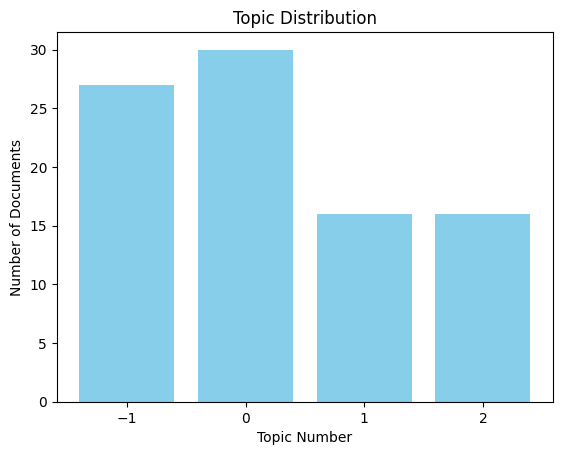

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'topics' contains the output from BERTopic
unique_topics, counts = np.unique(topics, return_counts=True)

# Simple bar chart to show topic distribution
plt.bar(unique_topics, counts, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.xticks(unique_topics)
plt.show()



### Top terms for each topic

In [ ]:
data = topic_model.get_topics()
rows = []
for topic, terms in data.items():
    for term, weight in terms:
        rows.append({'topic': topic, 'term': term, 'weight': weight})
df = pd.DataFrame(rows)
sorted_df = df.sort_values(by=['topic', 'weight'], ascending=[True, False])
print(sorted_df)

# Some practical considerations

In [24]:
# Load the dataset and read the first 100 rows
#file_path = 'Reviews.csv'
#df = pd.read_csv(file_path,nrows=100)
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=100)


## Preprocessing
Depending on the context, you may want to focus on terms that have a particular part-of-speech. For this case, let's only keep terms that are nouns and adjectives. Here are the steps to modify the `preprocess_text` function:

* Tokenize the text.
* Use part-of-speech tagging to identify the POS of each token.
* Filter out tokens that are not nouns or adjectives.
* Remove stopwords and non-alphabetic tokens.
* Join the tokens back into a string.

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens that are nouns or adjectives
    # NN* for nouns, JJ* for adjectives
    tokens = [word for word, tag in tagged_tokens if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    return ' '.join(tokens)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [26]:
# Remove rows where 'Review' is NaN
df = df.dropna(subset=['Review'])
df['Review']= df['Review'].apply(preprocess_text)

In [ ]:
df[['Review']]

In [28]:
# 'texts' will be a list of lists of tokens
texts = preprocess_texts(df['Review'])

dictionary = Dictionary(texts)

# Create a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA

In [29]:
# Set parameters
num_topics = 2
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.027*"size" + 0.015*"great" + 0.013*"bra" + 0.013*"suit" + 0.012*"fit" + 0.012*"small" + 0.010*"time" + 0.009*"look" + 0.009*"color" + 0.009*"top"')
(1, '0.017*"perfect" + 0.014*"comfortable" + 0.013*"color" + 0.013*"dress" + 0.012*"fit" + 0.011*"little" + 0.011*"size" + 0.011*"bra" + 0.010*"lace" + 0.009*"soft"')


## Choose the number of topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.2775663720454346, 0.3028677466800543, 0.33696836370938066, 0.3266251284126911]


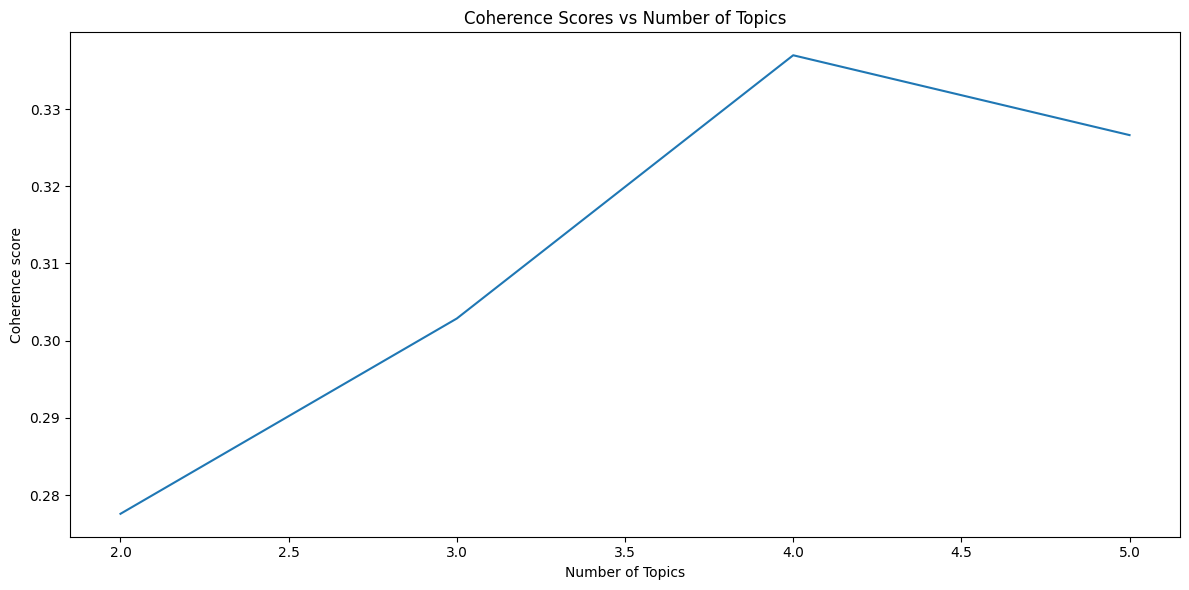

In [34]:
import matplotlib.pyplot as plt

# Range of topics to evaluate
topic_range = range(2, 6)

# List to store coherence
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=100)
    # Initialize CoherenceModel after training the LDA model
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    # Append the coherence score
    coherence_scores.append(coherence_lda)

print(coherence_scores)
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(topic_range, coherence_scores)
plt.title("Coherence Scores vs Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.tight_layout()
plt.show()

In [36]:
# Set optimal number of topics
num_topics = 4
passes = 10

# Create the LDA model
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Display the topics
topics = lda.print_topics(num_words=10)
for topic in topics:
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.025*"size" + 0.022*"suit" + 0.017*"comfortable" + 0.017*"piece" + 0.015*"small" + 0.015*"soft" + 0.013*"little" + 0.013*"fit" + 0.013*"first" + 0.013*"time"')
(1, '0.020*"size" + 0.017*"lace" + 0.015*"bra" + 0.015*"top" + 0.013*"good" + 0.013*"dress" + 0.011*"suit" + 0.011*"short" + 0.011*"fit" + 0.010*"cute"')
(2, '0.026*"perfect" + 0.017*"color" + 0.012*"fabric" + 0.012*"panty" + 0.012*"fit" + 0.012*"way" + 0.010*"soft" + 0.010*"flattering" + 0.010*"body" + 0.010*"black"')
(3, '0.025*"bra" + 0.024*"size" + 0.021*"great" + 0.017*"dress" + 0.015*"color" + 0.014*"little" + 0.014*"sweater" + 0.013*"fit" + 0.012*"comfortable" + 0.012*"strap"')


## Visualize

### Print top 5 terms in each topic

In [37]:
# Print the top 5 terms for each topic
for topic_id in range(num_topics):
    top_terms = lda.show_topic(topic_id, topn=5)  # Get the top 5 terms for this topic
    terms = ', '.join([term for term, _ in top_terms])
    print(f"Topic {topic_id}: {terms}")

Topic 0: size, suit, comfortable, piece, small
Topic 1: size, lace, bra, top, good
Topic 2: perfect, color, fabric, panty, fit
Topic 3: bra, size, great, dress, color


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Interactive Web-based Visualization

In [ ]:
%pip install pyLDAvis

In [39]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Assume `lda` is the LDA model and `corpus` and `dictionary` are your corpus and dictionary from Gensim

# Prepare the visualization data
vis_data = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization in a Jupyter Notebook (or in an IPython environment)
pyLDAvis.display(vis_data)

# To save the visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


# Your Turn
Conduct topic modeling with `sms_spam.csv`and `oct_delta.csv` data.

## **Practice 1**

Bertopic modelling

In [ ]:
%pip install bertopic

In [40]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
import pandas as pd

# Load the dataset and read the first 100 rows
file_path = 'sms_spam.csv'
df = pd.read_csv(file_path,nrows=100)

#df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Reviews.csv',nrows=100)

# Display the first few rows of the dataset and columns to identify the 'Review' column
df.head(), df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(   type                                               text
 0   ham  Go until jurong point, crazy.. Available only ...
 1   ham                      Ok lar... Joking wif u oni...
 2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
 3   ham  U dun say so early hor... U c already then say...
 4   ham  Nah I don't think he goes to usf, he lives aro...,
 Index(['type', 'text'], dtype='object'))

In [44]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Remove rows where 'Review' is NaN
df = df.dropna(subset=['text'])
df['text']= df['text'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
from bertopic import BERTopic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Initialize BERTopic
topic_model = BERTopic(language="english", calculate_probabilities=True)

# Fit the model on the limited data
topics, probabilities = topic_model.fit_transform(df['text'])

# Display the topic info
topic_info = topic_model.get_topic_info()
print(topic_info)

# Optionally, print individual topics
for topic in topic_model.get_topics().items():
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Topic  Count                   Name  \
0     -1     51    -1_sorry_like_lt_gt   
1      0     29   0_ok_home_go_tonight   
2      1     20  1_call_free_prize_txt   

                                      Representation  \
0  [sorry, like, lt, gt, smile, know, get, even, ...   
1  [ok, home, go, tonight, hi, want, ur, ha, stil...   
2  [call, free, prize, txt, cash, customer, sms, ...   

                                 Representative_Docs  
0  [smile pleasure smile pain smile trouble pours...  
1  [yup ok go home look timings msg xuhui going l...  
2  [winner valued network customer selected recei...  
(-1, [('sorry', 0.05509625649054758), ('like', 0.05334166787471007), ('lt', 0.0517908478686128), ('gt', 0.0517908478686128), ('smile', 0.0517908478686128), ('know', 0.04367976930639347), ('get', 0.034940231904863485), ('even', 0.034940231904863485), ('great', 0.034940231904863485), ('pain', 0.032759826979795105)])
(0, [('ok', 0.07387735352470542), ('home', 0.06372347343058257), ('go'

/usr/local/lib/python3.10/dist-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


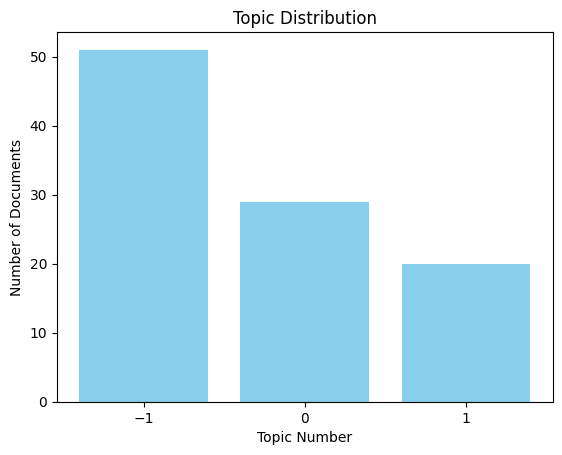

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'topics' contains the output from BERTopic
unique_topics, counts = np.unique(topics, return_counts=True)

# Simple bar chart to show topic distribution
plt.bar(unique_topics, counts, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.xticks(unique_topics)
plt.show()

In [50]:
data = topic_model.get_topics()
rows = []
for topic, terms in data.items():
    for term, weight in terms:
        rows.append({'topic': topic, 'term': term, 'weight': weight})
df = pd.DataFrame(rows)
sorted_df = df.sort_values(by=['topic', 'weight'], ascending=[True, False])
print(sorted_df)

    topic      term    weight
0      -1     sorry  0.055096
1      -1      like  0.053342
2      -1        lt  0.051791
3      -1        gt  0.051791
4      -1     smile  0.051791
5      -1      know  0.043680
6      -1       get  0.034940
7      -1      even  0.034940
8      -1     great  0.034940
9      -1      pain  0.032760
10      0        ok  0.073877
11      0      home  0.063723
12      0        go  0.061243
13      0   tonight  0.056221
14      0        hi  0.052712
15      0      want  0.052712
16      0        ur  0.050001
17      0        ha  0.050001
18      0     still  0.050001
19      0       way  0.050001
20      1      call  0.176718
21      1      free  0.127327
22      1     prize  0.080560
23      1       txt  0.073042
24      1      cash  0.064442
25      1  customer  0.064442
26      1       sms  0.064442
27      1     claim  0.060420
28      1    mobile  0.060420
29      1     reply  0.060420


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
